In [1]:
import nest_asyncio

nest_asyncio.apply()

**Author**: Phi Nguyen Xuan \
**Source**: https://fastapi.tiangolo.com/tutorial


# **1. Python Types Intro**


## **Type Hints Basics**

Type hints help you declare the types of variables and function parameters, improving code readability and editor support.


In [3]:
def get_full_name_without_hints(first_name, last_name):
    full_name = first_name.title() + " " + last_name.title()
    return full_name


# When using method, the editor will recommend available method for you
def get_full_name_with_hints(first_name: str, last_name: str) -> str:
    full_name = first_name.title() + " " + last_name.title()
    return full_name

## **Generic Types**

Use generic types like list, dict, tuple, and set with type parameters


In [5]:
from typing import List, Dict


def process_items(items: List[str]) -> Dict[str, int]:
    return {item.capitalize(): len(item) for item in items}

print(process_items(["apple", "banana", "cherry"]))

{'Apple': 5, 'Banana': 6, 'Cherry': 6}


## **Union and Optional Types**

Declare variables that can be of multiple types or None.


In [5]:
from typing import Union, Optional


# You can declare that a variable can be any of several types, for example, an int or a str.
def get_item_price(item: Union[str, int]) -> float:
    if isinstance(item, str):
        return 10.0
    return 20.0


# You can declare that a value could have a type, like str, but that it could also be None.
## Python 3.8+
def get_user_name(user_id: Union[int, None] = None) -> str:
    return


def get_user_name(user_id: Optional[int] = None) -> str:
    return


## Python 3.10+
def get_user_name(user_id: int | None = None) -> str:
    if user_id is None:
        return "Guest"
    return f"User{user_id}"


# print(get_item_price("apple"))
# print(get_item_price(123))
# print(get_user_name())
# print(get_user_name(42))

## **Classes as types**

You can also declare a class as the type of a variable


In [6]:
from pydantic import BaseModel


class Person:
    def __init__(self, name: str):
        self.name = name


def get_person_name(one_person: Person):
    return one_person.name


person1 = Person("A")
print(get_person_name(person1))

A


## **Pydantic Models**


Pydantic is a Python library to perform data validation.

- Powered by type hints
- Speed
- JSON Schema: easy integration


In [10]:
from datetime import datetime
from pydantic import BaseModel, PositiveInt


class User(BaseModel):
    id: int
    name: str = "John Doe"
    signup_ts: datetime | None  # Union[datetime, None]
    tastes: dict[str, PositiveInt]


external_data = {
    "id": 123,
    "signup_ts": "2019-06-01 12:22",
    "tastes": {
        "wine": 9,
        b"cheese": 7,
        "cabbage": "1",
    },
    "name": "phi",
}

user = User(**external_data)

print(user.id)
print(user.model_dump())

123
{'id': 123, 'name': 'phi', 'signup_ts': datetime.datetime(2019, 6, 1, 12, 22), 'tastes': {'wine': 9, 'cheese': 7, 'cabbage': 1}}


If validation fails, Pydantic will raise an error with a breakdown of what was wrong:

- Wrong data type
- Missing input


In [14]:
from datetime import datetime
from pydantic import BaseModel, PositiveInt, ValidationError
from pprint import pprint


class User(BaseModel):
    id: int
    name: str = "John Doe"
    signup_ts: datetime | None
    tastes: dict[str, PositiveInt]


external_data = {"id": "int", "tastes": {}, "signup_ts": None}

try:
    User(**external_data)
except ValidationError as e:
    pprint(e.errors())

[{'input': 'int',
  'loc': ('id',),
  'msg': 'Input should be a valid integer, unable to parse string as an '
         'integer',
  'type': 'int_parsing',
  'url': 'https://errors.pydantic.dev/2.9/v/int_parsing'}]


## **Type hints in FastAPI**


- Editor support.
- Type checks.
- Define requirements: from request path parameters, query parameters, headers, bodies, dependencies, etc.
- Convert data: from the request to the required type.
- Validate data: coming from each request.
- Generating automatic errors returned to the client when the data is invalid.
- Document the API using OpenAPI.


# **2. How to write API with FastAPI**


When building APIs, you normally use these specific HTTP methods to perform a specific action.

Normally you use:

- POST: to create data.
- GET: to read data.
- PUT: to update data.
- DELETE: to delete data.


## **Path parameter**


In [15]:
%%writefile app.py
import uvicorn
from fastapi import FastAPI

app = FastAPI()

@app.get("/items/{item_id}")
async def read_item(item_id: int):
    return {"item_id": "This is information of " + str(item_id)}


if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

Overwriting app.py


## **Predefined values**


If you have a path operation that receives a path parameter, but you want the possible valid path parameter values to be predefined, you can use a standard Python Enum.


In [16]:
%%writefile app.py
import uvicorn
from enum import Enum
from fastapi import FastAPI


class ModelName(str, Enum):
    alexnet = "alexnet"
    resnet = "resnet"
    lenet = "lenet"


app = FastAPI()


@app.get("/models/{model_name}")
async def get_model(model_name: ModelName):
    if model_name is ModelName.alexnet:
        return {"model_name": model_name, "message": "Deep Learning FTW!"}

    if model_name.value == "lenet":
        return {"model_name": model_name, "message": "LeCNN all the images"}

    return {"model_name": model_name, "message": "Have some residuals"}


if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

Overwriting app.py


## **Query Parameters**


When you declare other function parameters that are not part of the path parameters, they are automatically interpreted as "query" parameters.


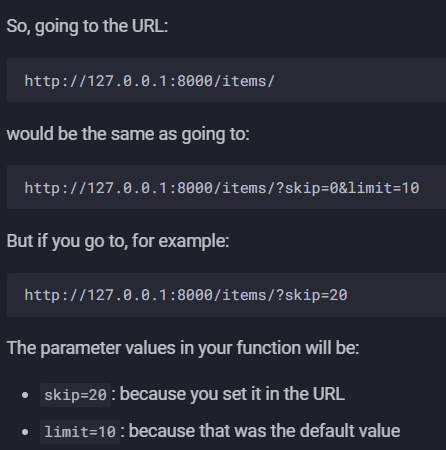


In [17]:
%%writefile app.py
import uvicorn
from fastapi import FastAPI

app = FastAPI()

fake_items_db = [{"item_name": "Foo"}, {"item_name": "Bar"}, {"item_name": "Baz"}]


@app.get("/items/")
async def read_item(skip: int = 0, limit: int = 10):
    return fake_items_db[skip : skip + limit]


if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

Overwriting app.py


## **Query parameters type conversion**


short = [1, True, true, on, yes] ==> converted into **_True_** in Python


In [3]:
%%writefile app.py

import uvicorn
from typing import Union
from fastapi import FastAPI

app = FastAPI()


@app.get("/items/{item_id}")
async def read_item(item_id: str, q: Union[str, None] = None, short: bool = False):
    item = {"item_id": item_id}
    if q:
        item.update({"q": q})
    if not short:
        item.update(
            {"description": "This is an amazing item that has a long description"}
        )
    return item


if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

Overwriting app.py


## **Request Body**


A request body is data sent by the client to your API. A response body is the data your API sends to the client.


In [18]:
%%writefile app.py

import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel


class Item(BaseModel):
    name: str
    description: str | None = None
    price: float
    tax: float | None = None


app = FastAPI()


@app.post("/items/")
async def create_item(item: Item):
    item_dict = item.model_dump()
    if item.tax:
        price_with_tax = item.price + item.tax
        item_dict.update({"price_with_tax": price_with_tax})
    return item_dict


if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

Overwriting app.py


## **Request body + path + query parameters**


In [19]:
%%writefile app.py

import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel


class Item(BaseModel):
    name: str
    description: str | None = None
    price: float
    tax: float | None = None


app = FastAPI()


@app.put("/items/{item_id}")
async def update_item(item_id: int, item: Item, q: str | None = None):
    result = {"item_id": item_id, **item.dict()}
    if q:
        result.update({"q": q})
    return result


if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

Overwriting app.py


**Thank You!**


In [ ]:
# Command to run on Colab if you need!
# !uvicorn app:app --reload & npx localtunnel --port 8000 & curl ipv4.icanhazip.com